In [33]:
import matplotlib.pyplot as plt
import numpy as np
import nilearn
import numpy as np
import pandas as pd
from nilearn import datasets, plotting
from sklearn.feature_selection import SelectPercentile, f_classif
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit

In [34]:
ASD_NEGATIVE = 1
ASD_POSITIVE = 2

In [35]:
cg_mean, cg_std = np.loadtxt('./results/beta_optimization').T
g_mean, g_std = np.loadtxt('./results/beta_optimization_gd.csv').T
l = 20
betas = np.linspace(0, 2, 50)
g_mean = g_mean[:l]
g_std = g_std[:l]
betas = betas[:l]

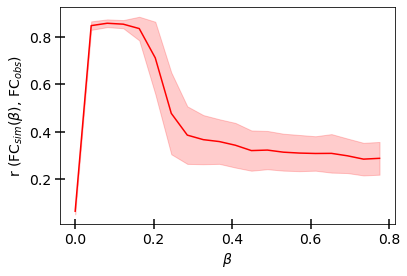

In [36]:
# plt.plot(betas, cg_mean, color='gray', label = 'Conjugate Gradient Descent')
# plt.fill_between(betas, cg_mean - cg_std, cg_mean + cg_std, color='gray', alpha=0.2)
plt.plot(betas, g_mean, color='red', label = 'Gradient Descent')
plt.fill_between(betas, g_mean - g_std, g_mean + g_std, color='red', alpha=0.2)
plt.xlabel(r'$\beta$', fontsize=14)
plt.ylabel(r'r (FC$_{sim}(\beta)$, FC$_{obs}$)', fontsize=14)
# plt.legend()
plt.tick_params(axis='both', which='major', direction='inout', length = 10, width = 1.5, labelsize='14')

In [37]:
betas

array([0.        , 0.04081633, 0.08163265, 0.12244898, 0.16326531,
       0.20408163, 0.24489796, 0.28571429, 0.32653061, 0.36734694,
       0.40816327, 0.44897959, 0.48979592, 0.53061224, 0.57142857,
       0.6122449 , 0.65306122, 0.69387755, 0.73469388, 0.7755102 ])

In [38]:
a = np.random.uniform(0, 1, size=(196, 0))

In [39]:
def top_pairs(scores, coordinates, n_rois = 116, k = 5):
    idx = np.argsort(scores)[-k:]
    rois = set() 
    pairs = set()
    rois_scores = {}
    for i in idx:
        r1 = i//n_rois
        r2 = i%n_rois
        rois.add(r1)
        rois.add(r2)
        pairs.add((r1, r2, scores[i]))
        rois_scores[r1] = scores[i]
        rois_scores[r2] = scores[i]

    rois = list(rois)
    coordinates = coordinates[rois]
    scores = scores.reshape(n_rois, n_rois)[rois][:, rois]
    return coordinates, scores, rois_scores, pairs

### Loading connectivity matrices 

In [40]:
diag = np.load('../data/AAL_reps/diag_NYU.npy')
ising_rep_ut = np.load('../data/AAL_reps/gd_NYU.npy')
ising_rep_mat = np.reshape(ising_rep_ut, (ising_rep_ut.shape[0], 116, 116))
ising_rep = ising_rep_ut
fc_rep_ut = np.load('../data/AAL_reps/sfc_NYU.npy')
fc_rep_mat = np.zeros((fc_rep_ut.shape[0], 116, 116))
fc_rep = np.zeros((fc_rep_ut.shape[0], 116*116))
for i in range(fc_rep_ut.shape[0]):
    fc_rep_mat[i][np.triu_indices(116, k=1)] = fc_rep_ut[i]
    fc_rep_mat[i] = np.triu(fc_rep_mat[i]) + np.tril(fc_rep_mat[i].T, k=-1)
    fc_rep[i] = fc_rep_mat[i].flatten()
print(ising_rep.shape, fc_rep.shape)
fs = SelectPercentile(f_classif, percentile=10)


FileNotFoundError: [Errno 2] No such file or directory: '../data/AAL_reps/gd_NYU.npy'

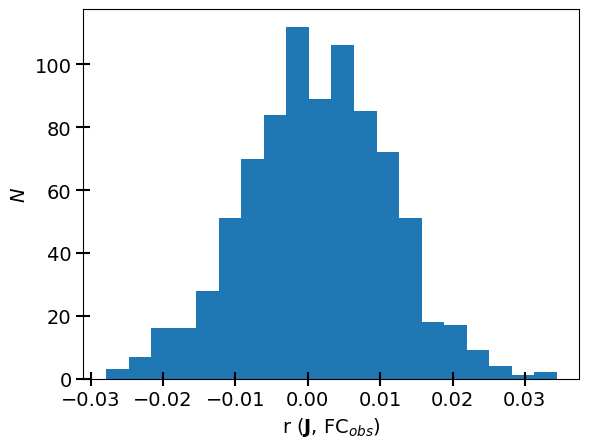

In [ ]:
corrs = []
for idx in range(ising_rep.shape[0]):
    corrs.append(np.corrcoef(ising_rep[idx], fc_rep[idx])[0][1])
corrs = np.array(corrs)
plt.hist(corrs, bins=20)
plt.xlabel(r'r ($\mathbf{J}$, FC$_{obs}$)', fontsize=14)
plt.ylabel(r'$N$', fontsize=14)
# plt.legend()
plt.tick_params(axis='both', which='major', direction='inout', length = 10, width = 1.5, labelsize='14')

(841,)

In [ ]:
ising_rep = fs.fit_transform(ising_rep, diag)
ising_scores = fs.scores_
fc_rep = fs.fit_transform(fc_rep, diag)
fc_scores = fs.scores_

NameError: name 'fs' is not defined

## ROI Distances

In [ ]:
aal = datasets.fetch_atlas_aal()
coordinates = plotting.find_parcellation_cut_coords(aal['maps'])
roi_dists = cdist(coordinates, coordinates)

In [ ]:
neg_diag_idxs = np.where(diag == ASD_NEGATIVE)[0]
pos_diag_idxs = np.where(diag == ASD_POSITIVE)[0]

In [ ]:
neg_diag_fc_rep = np.mean(fc_rep_mat[neg_diag_idxs], axis=0)
pos_diag_fc_rep = np.mean(fc_rep_mat[pos_diag_idxs], axis=0)
neg_diag_ising_rep = np.mean(ising_rep_mat[neg_diag_idxs], axis=0)
pos_diag_ising_rep = np.mean(ising_rep_mat[pos_diag_idxs], axis=0)
all_fc_rep = np.mean(fc_rep_mat, axis=0)
all_ising_rep = np.mean(ising_rep_mat, axis=0)

/home/anirudh/miniconda3/envs/research/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/anirudh/miniconda3/envs/research/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [ ]:
def get_dist_fc_ising (fc_rep, ising_rep, roi_dists):
    x_dists, y_fc, y_ising = [], [], []
    for i in range(len(fc_rep)):
        for j in range(i+1, len(fc_rep)):
            x_dists.append(roi_dists[i][j])
            y_fc.append(fc_rep[i][j])
            y_ising.append(ising_rep[i][j])
            # print(f"y_fc: {fc_rep[i][j]}, y_ising: {ising_rep}")
    return np.array(x_dists), np.array(y_fc), np.array(y_ising)

neg_x_dists, neg_y_fc, neg_y_ising = get_dist_fc_ising(neg_diag_fc_rep, neg_diag_ising_rep, roi_dists)
pos_x_dists, pos_y_fc, pos_y_ising = get_dist_fc_ising(pos_diag_fc_rep, pos_diag_ising_rep, roi_dists)
all_x_dists, all_y_fc, all_y_ising = get_dist_fc_ising(all_fc_rep, all_ising_rep, roi_dists)

Text(0.5, 1.0, 'FC vs ROI Distance')

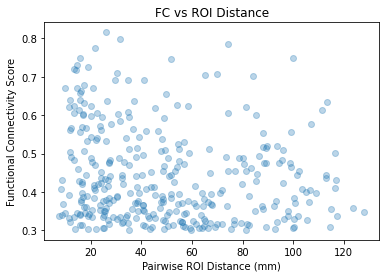

In [ ]:
plt.scatter(all_x_dists[all_y_fc > 0.3], all_y_fc[all_y_fc > 0.3], alpha=0.3)
plt.xlabel("Pairwise ROI Distance (mm)")
plt.ylabel("Functional Connectivity Score")
plt.title("FC vs ROI Distance")

ValueError: x and y must have same first dimension, but have shapes (728,) and (1,)

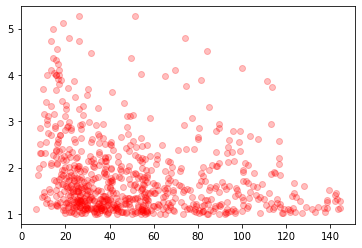

In [ ]:
plt.scatter(all_x_dists[all_y_ising > 1], all_y_ising[all_y_ising > 1], alpha=0.25, color='red')
plt.plot(all_x_dists[all_y_ising > 1], np.mean(all_y_ising[all_y_ising > 1]))
plt.xlabel("Pairwise ROI Distance (mm)")
plt.ylabel("Connectivity Strength")
plt.title("Ising Pairwise Connection vs ROI Distance for ASD-allative Group")

Text(0.5, 1.0, 'FC vs ROI Distance for ASD-Negative Group')

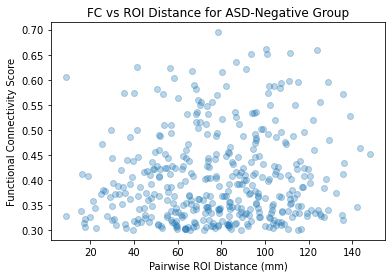

In [ ]:
plt.scatter(neg_x_dists[neg_y_fc > 0.3], neg_y_fc[neg_y_fc > 0.3], alpha=0.3)
plt.xlabel("Pairwise ROI Distance (mm)")
plt.ylabel("Functional Connectivity Score")
plt.title("FC vs ROI Distance for ASD-Negative Group")

Text(0.5, 1.0, 'Ising Pairwise Connection vs ROI Distance for ASD-Negative Group')

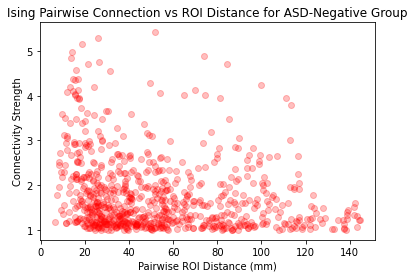

In [ ]:
plt.scatter(neg_x_dists[neg_y_ising > 1], neg_y_ising[neg_y_ising > 1], alpha=0.25, color='red')
plt.xlabel("Pairwise ROI Distance (mm)")
plt.ylabel("Connectivity Strength")
plt.title("Ising Pairwise Connection vs ROI Distance for ASD-Negative Group")

Text(0.5, 1.0, 'FC vs ROI Distance for ASD-Positive Group')

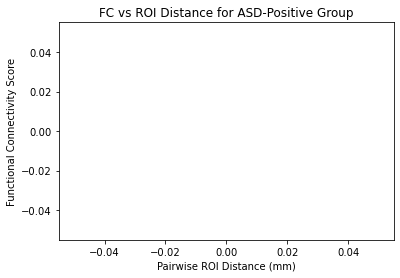

In [ ]:
plt.scatter(pos_x_dists[pos_y_fc > 0.3], pos_y_fc[pos_y_fc > 0.3], alpha=0.25)
plt.xlabel("Pairwise ROI Distance (mm)")
plt.ylabel("Functional Connectivity Score")
plt.title("FC vs ROI Distance for ASD-Positive Group")

Text(0.5, 1.0, 'Ising Pairwise Connection vs ROI Distance for ASD-Positive Group')

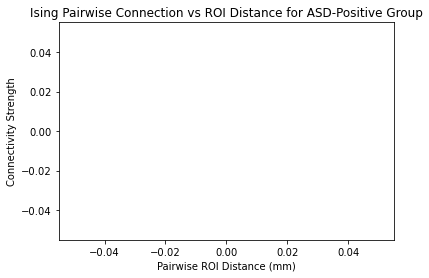

In [ ]:
plt.scatter(pos_x_dists[pos_y_ising > 1], pos_y_ising[pos_y_ising > 1], alpha=0.25, color='red')
plt.xlabel("Pairwise ROI Distance (mm)")
plt.ylabel("Connectivity Strength")
plt.title("Ising Pairwise Connection vs ROI Distance for ASD-Positive Group")

In [ ]:
is_coords, is_scores, is_rois, is_pairs = top_pairs(ising_scores, coordinates, k=5)
plotting.plot_connectome(is_scores, is_coords)

NameError: name 'ising_scores' is not defined

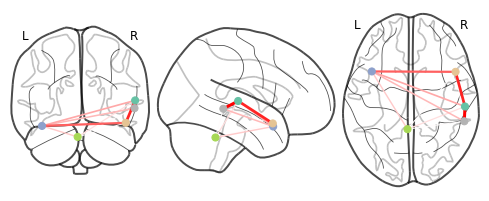

In [ ]:
fc_coords, f_scores, fc_rois, fc_pairs = top_pairs(fc_scores, coordinates, k=5)
plotting.plot_connectome(f_scores, fc_coords)

In [ ]:
labels = [(aal.labels[i], aal.labels[j], sc) for i, j, sc in fc_pairs]
labels

[('Frontal_Inf_Orb_L', 'Vermis_7', 37.98146452010402),
 ('Rolandic_Oper_L', 'Frontal_Mid_L', 46.401333426722246),
 ('Vermis_7', 'Frontal_Inf_Orb_L', 37.98146452010402),
 ('Frontal_Mid_L', 'Rolandic_Oper_L', 46.401333426722246),
 ('Frontal_Sup_Orb_R', 'Cerebelum_Crus1_L', 36.07735545427141)]

In [ ]:
labels = [(aal.labels[i], aal.labels[j], sc) for i, j, sc in is_pairs]
labels

[('Postcentral_L', 'Lingual_L', 16.294879978747908),
 ('Parietal_Inf_L', 'Paracentral_Lobule_L', 16.208868866706624),
 ('Occipital_Mid_R', 'Calcarine_L', 16.39882224049977),
 ('Vermis_3', 'Cuneus_R', 16.01626255510945),
 ('Calcarine_L', 'Occipital_Mid_R', 17.941764124924827)]
 ('', '', 0)]
[('Frontal_Med_Orb_R', 15.062930005568164),
 ('Cingulum_Post_R', 15.062930005568164),
 ('Temporal_Pole_Mid_L', 15.395610051080535),
 ('Supp_Motor_Area_R', 15.395610051080535),
 ('Cingulum_Post_L', 18.540943487318767),
 ('Lingual_R', 18.540943487318767),
 ('Supp_Motor_Area_L', 19.368740038783237),
 ('Cerebelum_10_R', 19.368740038783237)]

## ROI Distances

In [ ]:
fc_rep_ut = np.load('../data/AAL_reps/sfc_NYU.npy')
fc_rep_mat = np.zeros((fc_rep_ut.shape[0], 116, 116))
fc_rep = np.zeros((fc_rep_ut.shape[0], 116*116))
for i in range(fc_rep_ut.shape[0]):
    fc_rep_mat[i][np.triu_indices(116)] = fc_rep_ut[i]
    fc_rep_mat[i] = np.triu(fc_rep_mat[i]) + np.tril(fc_rep_mat[i].T, k=-1)
    fc_rep[i] = fc_rep_mat[i].flatten()

In [ ]:
ising_rep_mat = np.load('../data/AAL_reps/ising_NYU.npy')

In [ ]:
diag = np.load('../data/AAL_reps/diag_NYU.npy')

In [ ]:

coordinates = plotting.find_parcellation_cut_coords(aal['maps'])
roi_dists = cdist(coordinates, coordinates)
neg_diag_idxs = np.where(diag == 0)[0]
pos_diag_idxs = np.where(diag == 1)[0]

In [ ]:
neg_diag_fc_rep = np.mean(fc_rep_mat[neg_diag_idxs], axis=0)
pos_diag_fc_rep = np.mean(fc_rep_mat[pos_diag_idxs], axis=0)
neg_diag_ising_rep = np.mean(ising_rep_mat[neg_diag_idxs], axis=0)
pos_diag_ising_rep = np.mean(ising_rep_mat[pos_diag_idxs], axis=0)
all_fc_rep = np.mean(fc_rep_mat, axis=0)
all_ising_rep = np.mean(ising_rep_mat, axis=0)

In [ ]:
def get_dist_fc_ising (fc_rep, ising_rep, roi_dists):
    x_dists, y_fc, y_ising = [], [], []
    for i in range(len(fc_rep)):
        for j in range(i+1, len(fc_rep)):
            x_dists.append(roi_dists[i][j])
            y_fc.append(fc_rep[i][j])
            y_ising.append(ising_rep[i][j])
            # print(f"y_fc: {fc_rep[i][j]}, y_ising: {ising_rep}")
    y_fc = np.array(y_fc)
    y_fc[np.isnan(y_fc)] = 0
    return np.array(x_dists), np.array(y_fc), np.array(y_ising)

neg_x_dists, neg_y_fc, neg_y_ising = get_dist_fc_ising(neg_diag_fc_rep, neg_diag_ising_rep, roi_dists)
pos_x_dists, pos_y_fc, pos_y_ising = get_dist_fc_ising(pos_diag_fc_rep, pos_diag_ising_rep, roi_dists)
all_x_dists, all_y_fc, all_y_ising = get_dist_fc_ising(all_fc_rep, all_ising_rep, roi_dists)

Text(0.5, 1.0, 'FC vs ROI Distance')

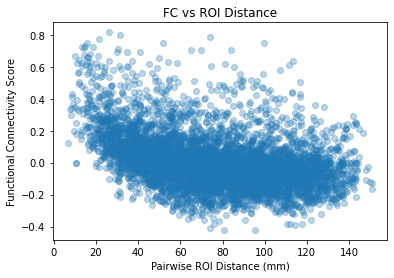

In [ ]:

plt.scatter(all_x_dists, all_y_fc, alpha=0.3)
plt.xlabel("Pairwise ROI Distance (mm)")
plt.ylabel("Functional Connectivity Score")
plt.title("FC vs ROI Distance")

Text(0.5, 1.0, 'Ising Pairwise Connection vs ROI Distance for ASD-allative Group')

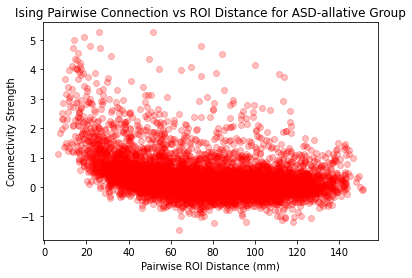

In [ ]:
plt.scatter(all_x_dists, all_y_ising, alpha=0.25, color='red')
# plt.plot(all_x_dists[all_y_ising > 1], np.mean(all_y_ising[all_y_ising > 1]))
plt.xlabel("Pairwise ROI Distance (mm)")
plt.ylabel("Connectivity Strength")
plt.title("Ising Pairwise Connection vs ROI Distance for ASD-allative Group")

## Power Law Plots

In [ ]:
def binned_mean(x, y, n_bins = 20):
    y = (y - np.mean(y))/np.std(y)
    x_binned = np.linspace(0, max(x), n_bins)
    data = []
    binz = {i: [] for i in range(len(x_binned))}
    for idx, i in enumerate(y):
        j = 0
        for v in x_binned: 
            if x[idx] <= v:
                break
            j+=1
        binz[j].append(y[idx])
    conn_mean = np.array([np.mean(i) for i in binz.values()])
    conn_std = np.array([np.std(i) for i in binz.values()]) 
    return x_binned[1:], conn_mean[1:], conn_std[1:]

In [ ]:
x, fc_mean, fc_std = binned_mean(all_x_dists, all_y_fc)
x, ising_mean, ising_std = binned_mean(all_x_dists, all_y_ising)

/home/anirudh/miniconda3/envs/research/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/anirudh/miniconda3/envs/research/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/anirudh/miniconda3/envs/research/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/anirudh/miniconda3/envs/research/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/anirudh/miniconda3/envs/research/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


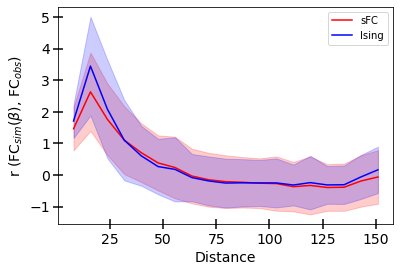

In [ ]:
plt.plot(x, fc_mean, color='red', label = 'sFC')
plt.plot(x, ising_mean, color='blue', label = 'Ising')
plt.fill_between(x, fc_mean - fc_std, fc_mean + fc_std, color='red', alpha=0.2)
plt.fill_between(x, ising_mean - ising_std, ising_mean + ising_std, color='blue', alpha=0.2)
plt.xlabel(r'Distance', fontsize=14)
plt.ylabel(r'r (FC$_{sim}(\beta)$, FC$_{obs}$)', fontsize=14)
plt.legend()
plt.tick_params(axis='both', which='major', direction='inout', length = 10, width = 1.5, labelsize='14')

In [ ]:
x, fc_neg_mean, fc_neg_std = binned_mean(neg_x_dists, neg_y_fc)
x, ising_neg_mean, ising_neg_std = binned_mean(neg_x_dists, neg_y_ising)
x, fc_pos_mean, fc_pos_std = binned_mean(pos_x_dists, pos_y_fc)
x, ising_pos_mean, ising_pos_std = binned_mean(pos_x_dists, pos_y_ising)

In [ ]:
fc_neg_mean, fc_pos_mean

(array([ 1.49060994,  2.69348181,  1.82236467,  1.15293   ,  0.74953022,
         0.40766993,  0.26073678, -0.01531854, -0.15198728, -0.22063191,
        -0.24924494, -0.28285089, -0.28951236, -0.38405853, -0.34259307,
        -0.42201841, -0.40176046, -0.19044073, -0.08686319]),
 array([ 1.42268041,  2.6566253 ,  1.7138637 ,  1.0631313 ,  0.66887888,
         0.36593757,  0.21684105, -0.04296523, -0.14515998, -0.20315701,
        -0.22074984, -0.2399257 , -0.25259669, -0.35703542, -0.32472547,
        -0.36513804, -0.38210174, -0.16969988,  0.09024377]))

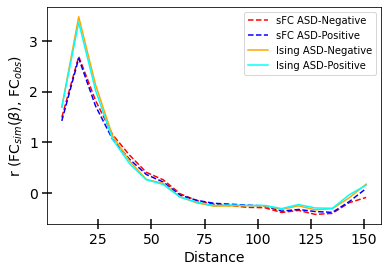

In [ ]:
plt.plot(x, fc_neg_mean, 'r--', label = 'sFC ASD-Negative')
# plt.fill_between(x, fc_neg_mean - fc_neg_std, fc_neg_mean + fc_neg_std, color='red', alpha=0.2)
plt.plot(x, fc_pos_mean, 'b--', label = 'sFC ASD-Positive')
# plt.fill_between(x, ising_neg_mean - ising_neg_std, ising_neg_mean + ising_neg_std, color='blue', alpha=0.2)

plt.plot(x, ising_neg_mean, color='orange', label = 'Ising ASD-Negative')
# plt.fill_between(x, fc_pos_mean - fc_pos_std, fc_pos_mean + fc_pos_std, color='red', alpha=0.2)
plt.plot(x, ising_pos_mean, color='cyan', label = 'Ising ASD-Positive')
# plt.fill_between(x, ising_pos_mean - ising_pos_std, ising_pos_mean + ising_pos_std, color='blue', alpha=0.2)

plt.xlabel(r'Distance', fontsize=14)
plt.ylabel(r'r (FC$_{sim}(\beta)$, FC$_{obs}$)', fontsize=14)
plt.legend()
plt.tick_params(axis='both', which='major', direction='inout', length = 10, width = 1.5, labelsize='14')

## Power Law Estimation

In [ ]:
def exponential(x, a=1, k=1):
    return a*np.exp(x*k)

In [ ]:
range_start, range_end = 2, -2
ising_pars, ising_cov = curve_fit(f=exponential, xdata=x[range_start:range_end], ydata=ising_mean[range_start:range_end], p0=[1, 0])
fc_pars, fc_cov = curve_fit(f=exponential, xdata=x[range_start:range_end], ydata=fc_mean[range_start:range_end], p0=[1, 0])

In [ ]:
print(f"Ising a: {ising_pars[0]}, k: {ising_pars[1]}")
print(f"FC a: {fc_pars[0]}, k: {fc_pars[1]}")

Ising a: 17.054740255061386, k: -0.0874649309331199
FC a: 10.223961808475371, k: -0.07210393751936296


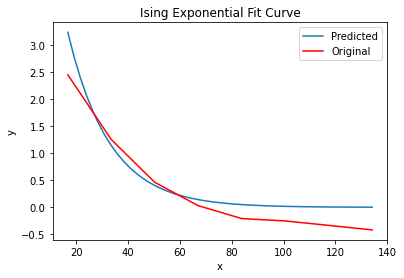

In [ ]:
xrange = np.linspace(x[range_start], x[range_end])

plt.plot(xrange, exponential(xrange, *ising_pars), label="Predicted")
plt.plot(x[range_start:range_end], fc_mean[range_start:range_end], color='red', label = 'Original')

plt.xlabel("x")
plt.ylabel("y")

plt.title("Ising Exponential Fit Curve")
plt.legend()


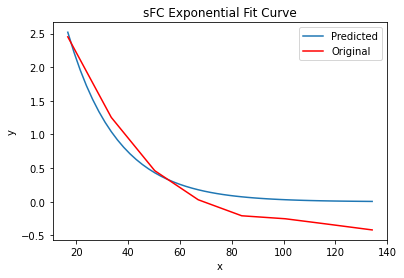

In [ ]:
xrange = np.linspace(x[0], x[plotlim])


plt.xlabel("x")
plt.ylabel("y")

# plt.text(0.5, 0.7, 'sdddsadash', snap=True)

plt.plot(xrange, exponential(xrange, *fc_pars), label="Predicted")
plt.plot(x[:plotlim+1], fc_mean[:plotlim+1], color='red', label = 'Original')

plt.title("sFC Exponential Fit Curve")
plt.legend()

plt.show()


## TEMP - Converting mica-mics metadata to ABIDE format

In [ ]:
meta_fp = "/home/anirudh/Research/Brain/Datasets/mica-mics-dataset/participants.tsv"
new_meta_fp = "/home/anirudh/Research/Brain/Datasets/mica-mics-dataset/metadata.csv"
metadata = pd.read_csv(meta_fp, sep='\t')
metadata

,participant_id,group,age,sex,handedness
0,sub-HC001,Healthy,20-25,M,R
1,sub-HC002,Healthy,20-25,M,L
2,sub-HC003,Healthy,40-45,M,R
3,sub-HC004,Healthy,25-30,M,R
4,sub-HC005,Healthy,30-35,F,R
5,sub-HC006,Healthy,35-40,M,R
6,sub-HC007,Healthy,25-30,F,R
7,sub-HC008,Healthy,25-30,F,R
8,sub-HC009,Healthy,20-25,M,R
9,sub-HC010,Healthy,35-40,M,R


In [ ]:
ages = list(metadata['age'])
averaged_ages = []
for age in ages:
    averaged_ages.append(int(age.split("-")[0]) + 2.5)

In [ ]:
new_metadata = [ 
    ['SUB_ID', 'SITE_ID', 'AGE_AT_SCAN', 'SEX', 'HANDEDNESS', 'DX_GROUP' ],
]

for i in range(len(metadata)):
    new_metadata.append([
        metadata.iloc[i]['participant_id'].split("-")[1].strip(),
        'all',
        averaged_ages[i],
        1 if metadata.iloc[i]['sex'] == 'M' else 2,
        1 if metadata.iloc[i]['handedness'] == 'R' else 2,
        1,
    ])

In [ ]:
new_metadata_pd = pd.DataFrame(new_metadata[1:], columns=new_metadata[0])
new_metadata_pd

,SUB_ID,SITE_ID,AGE_AT_SCAN,SEX,HANDEDNESS,DX_GROUP
0,HC001,all,22.5,1,1,1
1,HC002,all,22.5,1,2,1
2,HC003,all,42.5,1,1,1
3,HC004,all,27.5,1,1,1
4,HC005,all,32.5,2,1,1
5,HC006,all,37.5,1,1,1
6,HC007,all,27.5,2,1,1
7,HC008,all,27.5,2,1,1
8,HC009,all,22.5,1,1,1
9,HC010,all,37.5,1,1,1


## Shortening timeseries data

### Averaging Strategy

In [44]:
timeseries_dir = '/home/anirudh/Research/Brain/Datasets/mica-mics-dataset/timeseries'
subjects = list(new_metadata_pd['SUB_ID'])

In [47]:
def get_sub_ts(sub):
    return np.loadtxt(os.path.join(timeseries_dir, sub + "_timeseries.txt"))

In [42]:
def compress_ts_avg(ts, step=4):
    new_data = []
    for i in range(0, len(ts), step):
        new_data.append(np.mean(ts[i:i+step]))
        # for j in range(step): new_data.append(np.mean(ts[i:i+step]))
    return np.array(new_data)

Text(0.5, 0, 't')

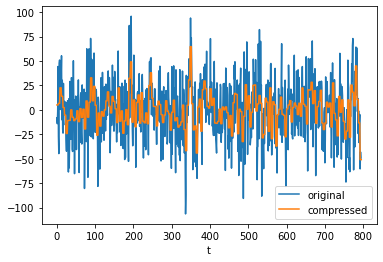

In [48]:
# Plotting sample
sub_ind, roi_ind = 1, 5
step = 4

sub = subjects[sub_ind]
ts_data = get_sub_ts(sub)
plt.plot(range(ts_data.shape[0]), ts_data[:, roi_ind], label="original")

compressed_ts = compress_ts_avg(ts_data[:, roi_ind], step=step)
overlay_compressed_ts = []
for i in compressed_ts:
    for j in range(step):
        overlay_compressed_ts.append(i)
overlay_compressed_ts = np.array(overlay_compressed_ts)

plt.plot(range(overlay_compressed_ts.shape[0]), overlay_compressed_ts, label="compressed")
plt.legend()
plt.xlabel('t')

### Slicing strategy

In [46]:
cutoff = 200

In [51]:
for sub in subjects:
    ts_data = get_sub_ts(sub)
    new_ts_data = ts_data[:cutoff]
    np.savetxt(os.path.join(timeseries_dir, sub + "_timeseries_sliced.txt"),
        new_ts_data)